In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pygeoda
import geojson as jg
from shapely.geometry import Point, Polygon
import altair as alt
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.stats import f_oneway
import pysal
import pysal.explore
import pysal.lib
from matplotlib import font_manager
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy


### READ IN CRIME DATA/ CHICAGO SHAPEFILE ###

In [5]:
df= gpd.read_file("chicago_comm_utm.shp")
crime_df = pd.read_csv("CTA_Crime_20240131.csv")
final_df = df.merge(crime_df, how='right', left_on='NID', right_on='Community Area')
final_df.to_file("final_df.shp")


**CRIME RATE CALCULATION**

In [ ]:
df_true = final_df[final_df['Arrest'] == True]
df_true["Arrest"] = df_true['Arrest'].replace({True: 1})


df_false =final_df[final_df['Arrest'] == False]
df_false["Arrest"] = df_false['Arrest'].replace({False: 1})

grouped_false = df_false.groupby('Community Area')['Arrest'].sum().reset_index()
grouped_true = df_true.groupby('Community Area')['Arrest'].sum().reset_index()

grouped_false = grouped_false.rename(columns={'Arrest': 'Arrest_false'})
grouped_true = grouped_true.rename(columns={'Arrest': 'Arrest_true'})

aggregated_df =final_df.groupby('Community Area').agg({
    'POP2010': 'mean',   # Keeping the population, latitude, longitude the same, avg of pop)
    'Latitude': 'first',
    'Longitude': 'first',
    'Ward':'first',
}).reset_index()

merged_df = pd.merge(aggregated_df, grouped_true, on='Community Area', how='left')
merged_df = pd.merge(merged_df, grouped_false, on='Community Area', how='left')
merged_df.fillna(0, inplace=True)


merged_df["crime count"] = merged_df["Arrest_true"]+merged_df["Arrest_false"]


#crime rate for every 10,000
merged_df['crime rate'] = merged_df['crime count'] * 10000 / merged_df['POP2010']
final_df2 = df.merge(merged_df, how='right', left_on='NID', right_on='Community Area')
final_df2.to_file("final_df2.shp")


**CRIME RATE VISUALIZATION**

In [ ]:

final_df2['log'] = np.log(final_df2['crime rate'] + 1)

# Percentile-based breaks
p_breaks = np.percentile(final_df2['log'], [25, 50, 75, 100])

fig, ax = plt.subplots(figsize=(20, 8)) 
final_df2.plot(column='log', cmap='Blues', legend=True, ax=ax, 
                scheme='User_Defined', classification_kwds={'bins': p_breaks})
final_df2.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
ax.set_title('CTA Crime Rate Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times new Roman'})
ax.set_xticks([]) 
ax.set_yticks([])  


# percentiles legennd
percentile_legend = ax.get_legend() 
for text in percentile_legend.get_texts():
    text.set_text('')

new_labels = ['0-25th Percentile', '26th-50th Percentile', '51st-75th Percentile', '76th-100th Percentile']
font_properties = font_manager.FontProperties(family='Times New Roman', size=12)
for label, new_label in zip(percentile_legend.get_texts(), new_labels):
    label.set_text(new_label)
    label.set_font_properties(font_properties)
percentile_legend.set_bbox_to_anchor((0.35, 0.14))


#top arrest plot
top_n = 4  
top_arrests = final_df2.nlargest(top_n, 'Arrest_true') 
for idx, row in top_arrests.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.scatter(x, y, color='red', marker='h', s=300, alpha=0.6, edgecolor='black', linewidth=2)

#no arrest plot
top_n2 = 4  
top_no_arrests = final_df2.nlargest(top_n2, 'Arrest_false')  
for idx, row in top_no_arrests.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.scatter(x, y, color='white', marker='P', s=150, alpha=0.6, edgecolor='black', linewidth=2)

arrest_marker = plt.Line2D([0], [0], marker='h', color='w', markerfacecolor='red', markersize=10, markeredgewidth=2, markeredgecolor='black', label='Top Arrest Areas')
no_arrest_marker = plt.Line2D([0], [0], marker='P', color='w', markerfacecolor='white', markersize=10, markeredgewidth=2, markeredgecolor='black', label='Top No Arrest Areas')


ax.legend(handles=[arrest_marker, no_arrest_marker], title='Arrest Indicators', loc='upper right', fontsize='small',
          prop={'family': 'Times New Roman', 'size': 10})
ax.add_artist(percentile_legend)

plt.tight_layout()
plt.savefig('Cta_final.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution (300 DPI)
plt.show()


**KERNEL DENSITY OF CRIME TYPE**

In [ ]:
intensity_data2=[]

crime_types2 = final_df['Primary Type'].unique()
bandwidth = 0.02  

# Iterate over each crime type
for crime_type in crime_types2:
    subset = final_df[final_df['Primary Type'] == crime_type]
    subset = subset.dropna(subset=['Latitude', 'Longitude'])

    coordinates = subset[['Latitude', 'Longitude']].values
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(coordinates)
    
    x = np.linspace(min(subset['Longitude']), max(subset['Longitude']), 100)
    y = np.linspace(min(subset['Latitude']), max(subset['Latitude']), 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
    
    intensity_df2 = pd.DataFrame({
        'Latitude': Y.ravel(),
        'Longitude': X.ravel(),
        'Intensity': Z.ravel(),
        'Crime_Type_Dec': crime_type  
    })
    intensity_data2.append(intensity_df2)
    
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(8, 4))
    plt.contourf(X, Y, Z, cmap='Reds')
    plt.colorbar(label='Density')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Kernel Density Estimation for {crime_type}')
    plt.savefig(f'Kernel_Density_{crime_type}.png', dpi=300, bbox_inches='tight') 
    plt.show()
    

**HIERARCHIAL DISTANCE OF PRIMARY CRIME TYPES**

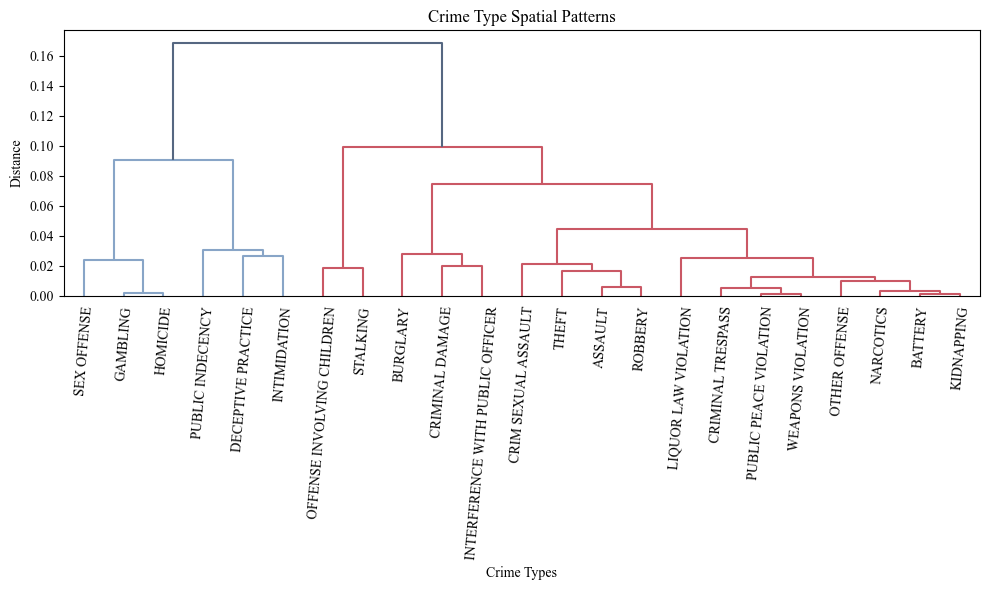

In [74]:

plt.rcParams['font.family'] = 'Times New Roman'

crime_types = final_df['Primary Type'].unique()  
spatial_data = final_df.groupby('Primary Type')[['Latitude', 'Longitude']].mean() 
distance_matrix = pdist(spatial_data, metric='euclidean')
Z = linkage(distance_matrix, method='ward')
hierarchy.set_link_color_palette(['#88A5C7', '#CA5865'])

plt.figure(figsize=(10, 6))
dendrogram(Z, 
           labels=spatial_data.index, 
           leaf_rotation=85,
           above_threshold_color='#556781')

plt.title('Crime Type Spatial Patterns')
plt.xlabel('Crime Types')
plt.ylabel('Distance')
plt.tight_layout()

hierarchy.set_link_color_palette(None)

plt.show()
